# 01 — Exploratory Data Analysis: Lending Club 2007–2020

**Objective**: Understand the structure, distributions, and risk patterns in the Lending Club loan dataset before modeling.

**Dataset**: `loan_master.parquet` — 1.35M loans (training set, pre-2018) with 32 feature-engineered columns.

**Sections**:
1. Data Loading & Overview
2. Data Quality & Missing Values
3. Target Variable Analysis
4. Univariate Distributions (Numeric)
5. Categorical Variable Analysis
6. Bivariate Analysis: Default Rate by Segment
7. Temporal Trends
8. Correlation Analysis
9. Outlier Detection
10. Key Findings & Next Steps

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from pathlib import Path

# Style
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "figure.dpi": 100,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
})

# Color palette for default/non-default
COLORS_DEFAULT = {0: "#2ecc71", 1: "#e74c3c"}
LABEL_DEFAULT = {0: "Fully Paid", 1: "Default"}

DATA_DIR = Path("../data/processed")
print("Setup complete.")

Setup complete.


---
## 1. Data Loading & Overview

In [2]:
df = pd.read_parquet(DATA_DIR / "loan_master.parquet")
print(f"Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")
print(f"Date range: {df['issue_d'].min().strftime('%Y-%m')} to {df['issue_d'].max().strftime('%Y-%m')}")
df.head(3)

Shape: 1,346,311 rows x 32 columns


Memory usage: 1009.0 MB
Date range: 2007-06 to 2017-03


,loan_amnt,annual_inc,loan_to_income,dti,rev_utilization,num_delinq_2yrs,days_since_last_delinq,int_rate_bucket,int_rate_bucket__grade,int_rate,...,total_acc,fico_range_low,fico_range_high,credit_history_months,early_delinq,loan_to_income_sq,default_flag,issue_d,loan_status,id
0,7500.0,22000.0,0.340909,14.29,0.515,1.0,330.0,medium,medium__E,13.75,...,8.0,660.0,664.0,44.633333,1,0.116219,0,2007-06-01,Fully Paid,87023
1,5000.0,150000.0,0.033333,0.00,0.195,0.0,0.0,very_low,very_low__A,7.43,...,19.0,775.0,779.0,238.400000,0,0.001111,0,2007-07-01,Fully Paid,90966
2,5750.0,125000.0,0.046000,0.27,0.102,0.0,0.0,very_low,very_low__A,7.43,...,16.0,790.0,794.0,249.533333,0,0.002116,0,2007-07-01,Fully Paid,99009


In [3]:
# Data types summary
dtype_summary = pd.DataFrame({
    "dtype": df.dtypes,
    "nunique": df.nunique(),
    "null_pct": (df.isnull().mean() * 100).round(2),
    "sample": df.iloc[0],
})
dtype_summary

,dtype,nunique,null_pct,sample
loan_amnt,float64,1547,0.00,7500.0
annual_inc,float64,64989,0.00,22000.0
loan_to_income,float64,161539,0.01,0.340909
dti,float64,5711,0.01,14.29
rev_utilization,float64,1383,0.06,0.515
num_delinq_2yrs,float64,29,0.00,1.0
days_since_last_delinq,float64,161,49.83,330.0
int_rate_bucket,category,5,0.00,medium
int_rate_bucket__grade,object,25,0.00,medium__E
int_rate,float64,575,0.00,13.75


In [4]:
# Descriptive statistics — numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
loan_amnt,1346311.0,14523.94,8630.34,500.00,8000.00,12000.00,20000.00,4.000000e+04
annual_inc,1346311.0,76377.08,69595.10,0.00,46000.00,65000.00,90000.00,9.573072e+06
loan_to_income,1346243.0,0.30,46.67,0.00,0.13,0.20,0.29,3.500000e+04
dti,1346237.0,18.32,9.24,-1.00,11.99,17.77,24.17,9.990000e+02
rev_utilization,1345568.0,0.53,0.24,0.00,0.35,0.54,0.72,8.920000e+00
num_delinq_2yrs,1346311.0,0.33,0.89,0.00,0.00,0.00,0.00,3.900000e+01
days_since_last_delinq,675456.0,1018.46,656.54,0.00,450.00,930.00,1470.00,5.850000e+03
int_rate,1346311.0,13.12,4.60,5.32,9.71,12.74,15.80,3.099000e+01
term,1346311.0,42.07,10.43,36.00,36.00,36.00,60.00,6.000000e+01
installment,1346311.0,438.19,257.44,4.93,251.58,377.04,578.42,1.715420e+03


---
## 2. Data Quality & Missing Values

In [5]:
# Missing values analysis
null_stats = (
    df.isnull().sum()
    .to_frame("null_count")
    .assign(null_pct=lambda x: (x["null_count"] / len(df) * 100).round(2))
    .query("null_count > 0")
    .sort_values("null_pct", ascending=False)
)
print(f"Columns with nulls: {len(null_stats)} of {df.shape[1]}")
null_stats

Columns with nulls: 7 of 32


,null_count,null_pct
days_since_last_delinq,670855,49.83
emp_length,76299,5.67
rev_utilization,743,0.06
revol_util,743,0.06
loan_to_income,68,0.01
dti,74,0.01
loan_to_income_sq,68,0.01


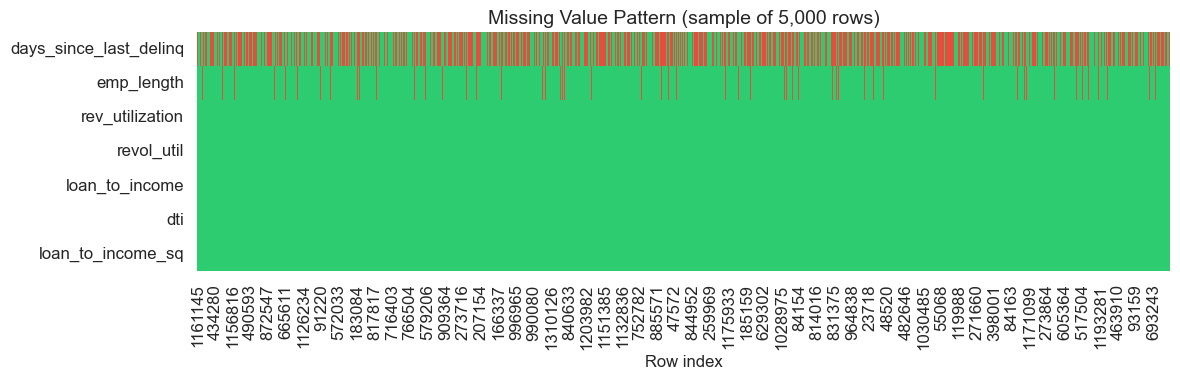

In [6]:
# Missing value heatmap (only columns with nulls)
if len(null_stats) > 0:
    cols_with_nulls = null_stats.index.tolist()
    fig, ax = plt.subplots(figsize=(12, 4))
    sample = df[cols_with_nulls].sample(min(5000, len(df)), random_state=42)
    sns.heatmap(
        sample.isnull().T, cbar=False, yticklabels=True,
        cmap=["#2ecc71", "#e74c3c"], ax=ax
    )
    ax.set_title("Missing Value Pattern (sample of 5,000 rows)")
    ax.set_xlabel("Row index")
    plt.tight_layout()
    plt.show()
else:
    print("No missing values in this dataset.")

> **Note**: `days_since_last_delinq` has ~50% nulls — this is **expected** since only borrowers with a prior delinquency have this field populated. `emp_length` has ~6% nulls. CatBoost handles NaN natively, so no imputation is needed for tree models.

---
## 3. Target Variable Analysis

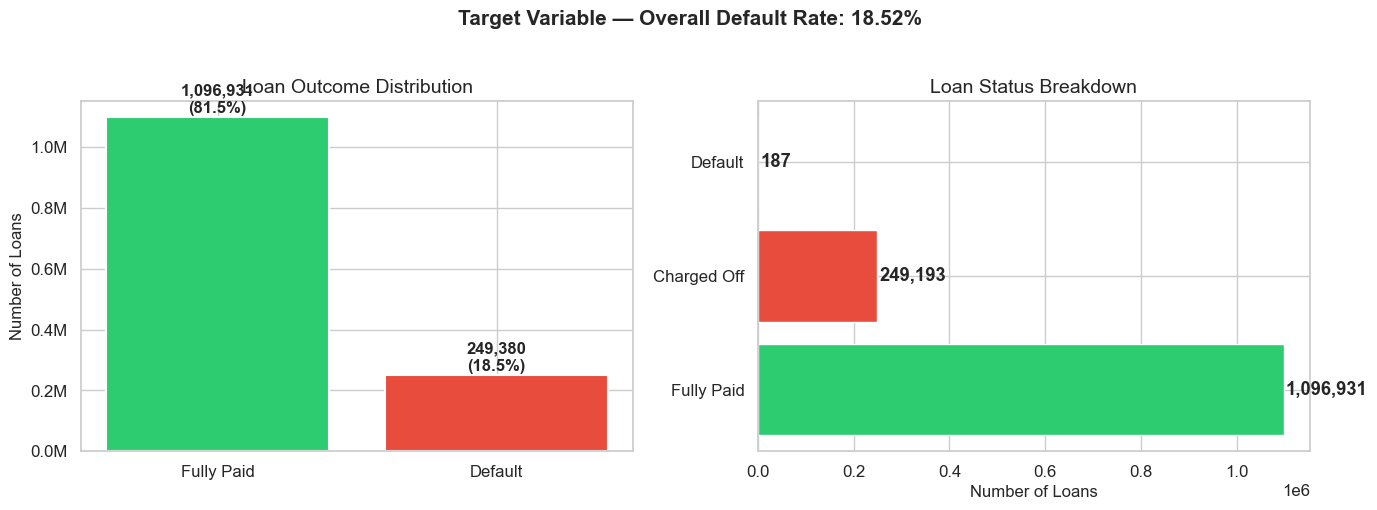


Default rate: 0.1852 (18.52%)
Class imbalance ratio (non-default : default): 4.4:1


In [7]:
# Default flag distribution
default_counts = df["default_flag"].value_counts().sort_index()
default_rate = df["default_flag"].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
bars = axes[0].bar(
    [LABEL_DEFAULT[i] for i in default_counts.index],
    default_counts.values,
    color=[COLORS_DEFAULT[i] for i in default_counts.index],
    edgecolor="white", linewidth=1.5
)
for bar, val in zip(bars, default_counts.values):
    axes[0].text(
        bar.get_x() + bar.get_width() / 2, bar.get_height() + 5000,
        f"{val:,}\n({val/len(df)*100:.1f}%)",
        ha="center", va="bottom", fontweight="bold", fontsize=12
    )
axes[0].set_title("Loan Outcome Distribution")
axes[0].set_ylabel("Number of Loans")
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))

# Loan status breakdown
status_counts = df["loan_status"].value_counts()
colors_status = ["#2ecc71", "#e74c3c", "#c0392b"]
axes[1].barh(status_counts.index, status_counts.values, color=colors_status[:len(status_counts)])
for i, (val, name) in enumerate(zip(status_counts.values, status_counts.index)):
    axes[1].text(val + 5000, i, f"{val:,}", va="center", fontweight="bold")
axes[1].set_title("Loan Status Breakdown")
axes[1].set_xlabel("Number of Loans")

fig.suptitle(f"Target Variable — Overall Default Rate: {default_rate:.2%}", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

print(f"\nDefault rate: {default_rate:.4f} ({default_rate:.2%})")
print(f"Class imbalance ratio (non-default : default): {(1-default_rate)/default_rate:.1f}:1")

---
## 4. Univariate Distributions (Numeric)

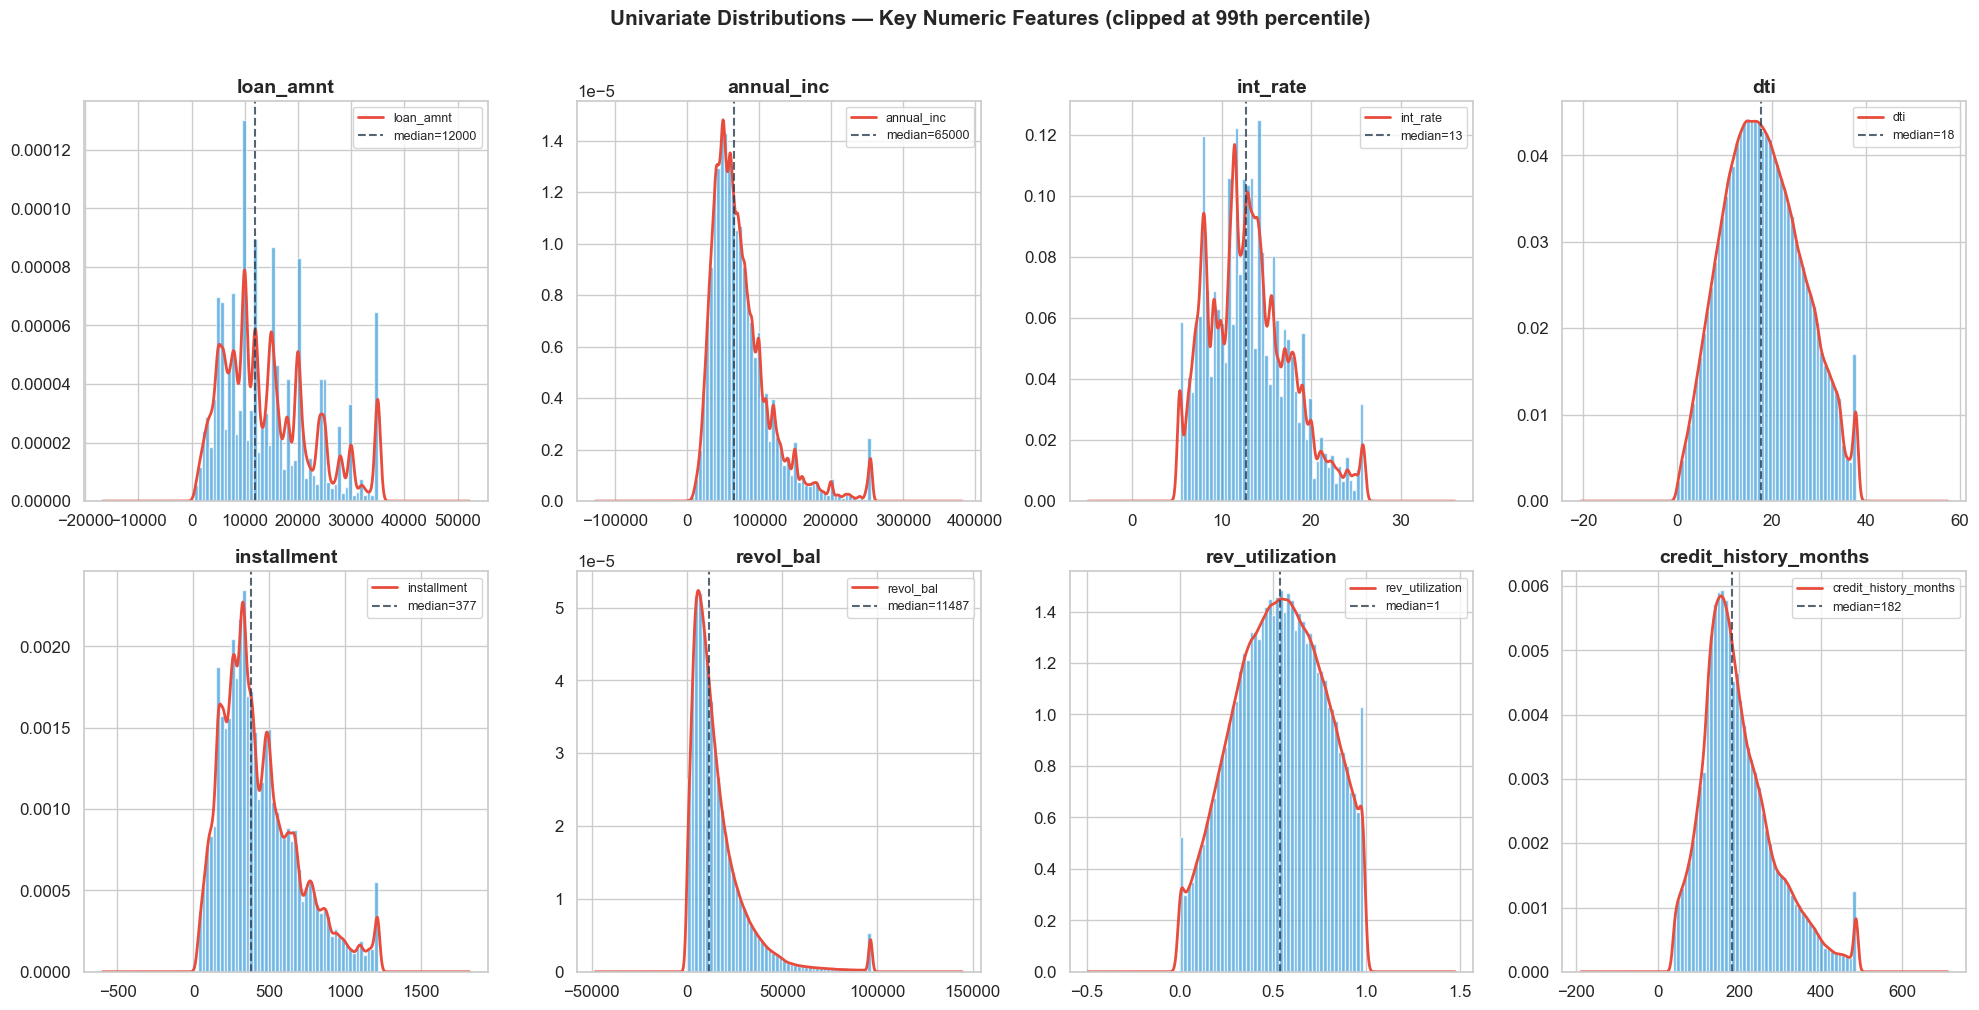

In [8]:
# Key numeric features — histograms with KDE
plot_features = ["loan_amnt", "annual_inc", "int_rate", "dti",
                 "installment", "revol_bal", "rev_utilization", "credit_history_months"]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(plot_features):
    data = df[col].dropna()
    q99 = data.quantile(0.99)
    data_clipped = data.clip(upper=q99)

    axes[i].hist(data_clipped, bins=50, color="#3498db", alpha=0.7, edgecolor="white", density=True)
    try:
        data_clipped.plot.kde(ax=axes[i], color="#e74c3c", linewidth=2)
    except Exception:
        pass
    axes[i].set_title(col, fontweight="bold")
    axes[i].set_ylabel("")
    axes[i].axvline(data.median(), color="#2c3e50", linestyle="--", alpha=0.8, label=f"median={data.median():.0f}")
    axes[i].legend(fontsize=9)

fig.suptitle("Univariate Distributions — Key Numeric Features (clipped at 99th percentile)",
             fontsize=15, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

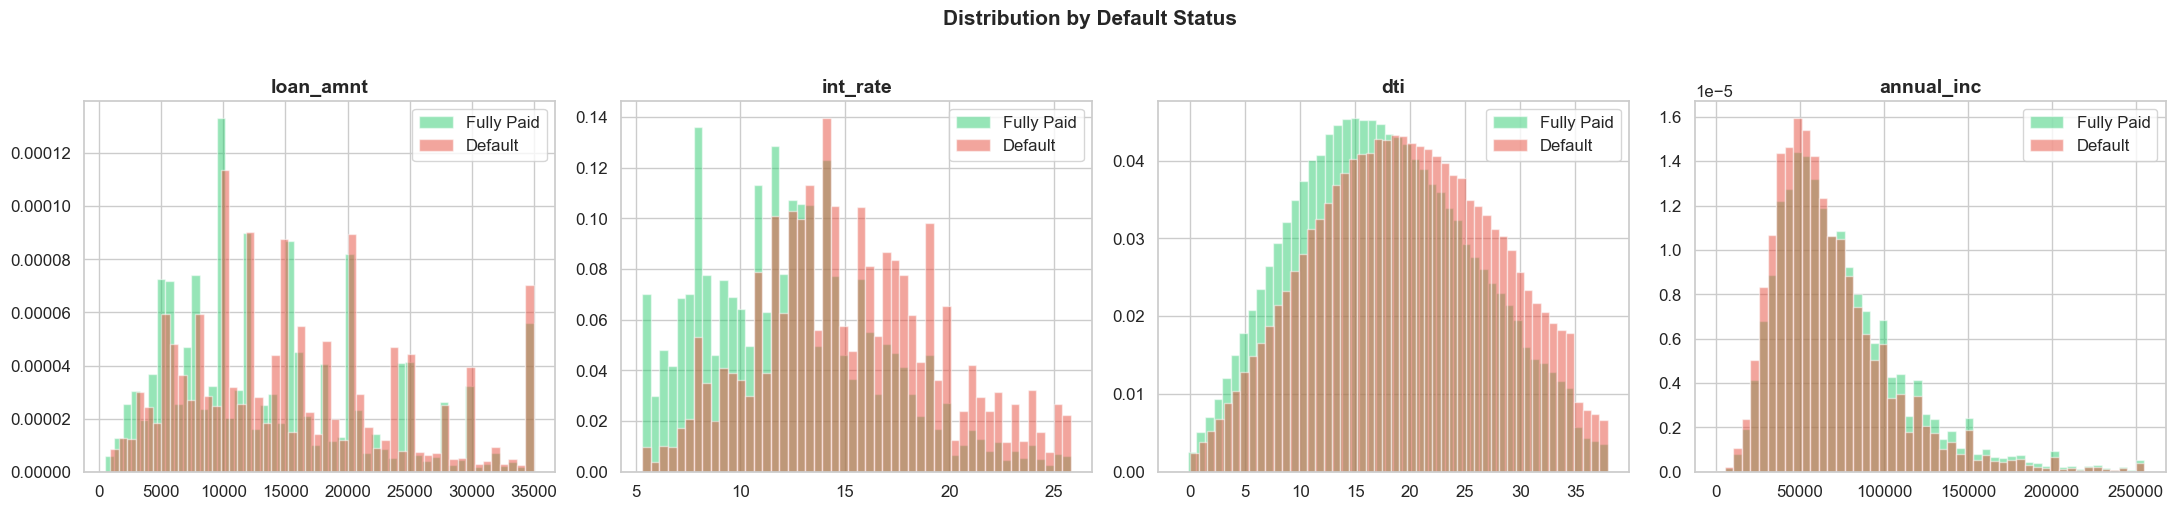

In [9]:
# Distributions split by default flag
key_features = ["loan_amnt", "int_rate", "dti", "annual_inc"]

fig, axes = plt.subplots(1, 4, figsize=(22, 5))
for i, col in enumerate(key_features):
    data = df[[col, "default_flag"]].dropna()
    q99 = data[col].quantile(0.99)
    data = data[data[col] <= q99]

    for flag in [0, 1]:
        subset = data[data["default_flag"] == flag][col]
        axes[i].hist(subset, bins=50, alpha=0.5, density=True,
                     color=COLORS_DEFAULT[flag], label=LABEL_DEFAULT[flag])

    axes[i].set_title(col, fontweight="bold")
    axes[i].legend()

fig.suptitle("Distribution by Default Status", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

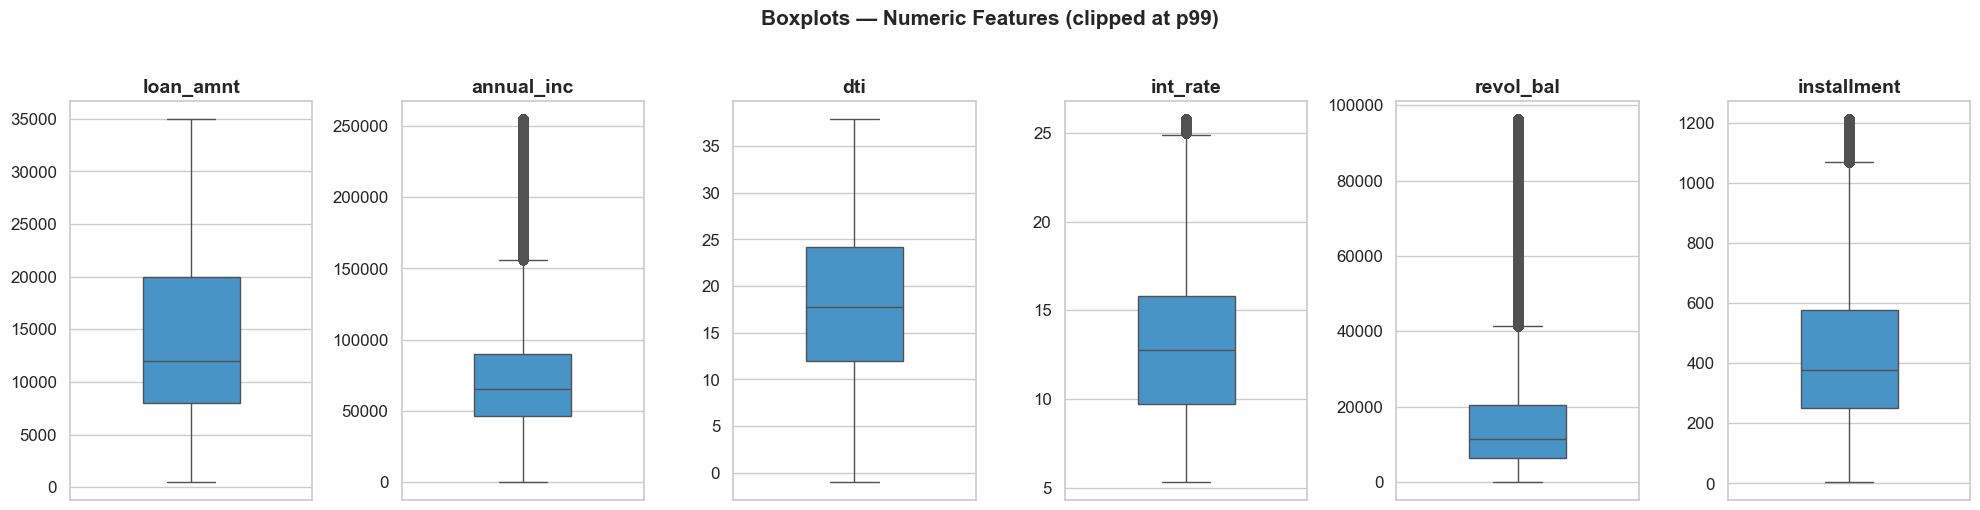

In [10]:
# Boxplots for outlier visualization
box_features = ["loan_amnt", "annual_inc", "dti", "int_rate", "revol_bal", "installment"]

fig, axes = plt.subplots(1, len(box_features), figsize=(20, 5))
for i, col in enumerate(box_features):
    data = df[col].dropna()
    q99 = data.quantile(0.99)
    sns.boxplot(y=data.clip(upper=q99), ax=axes[i], color="#3498db", width=0.4)
    axes[i].set_title(col, fontweight="bold")
    axes[i].set_ylabel("")

fig.suptitle("Boxplots — Numeric Features (clipped at p99)", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

---
## 5. Categorical Variable Analysis

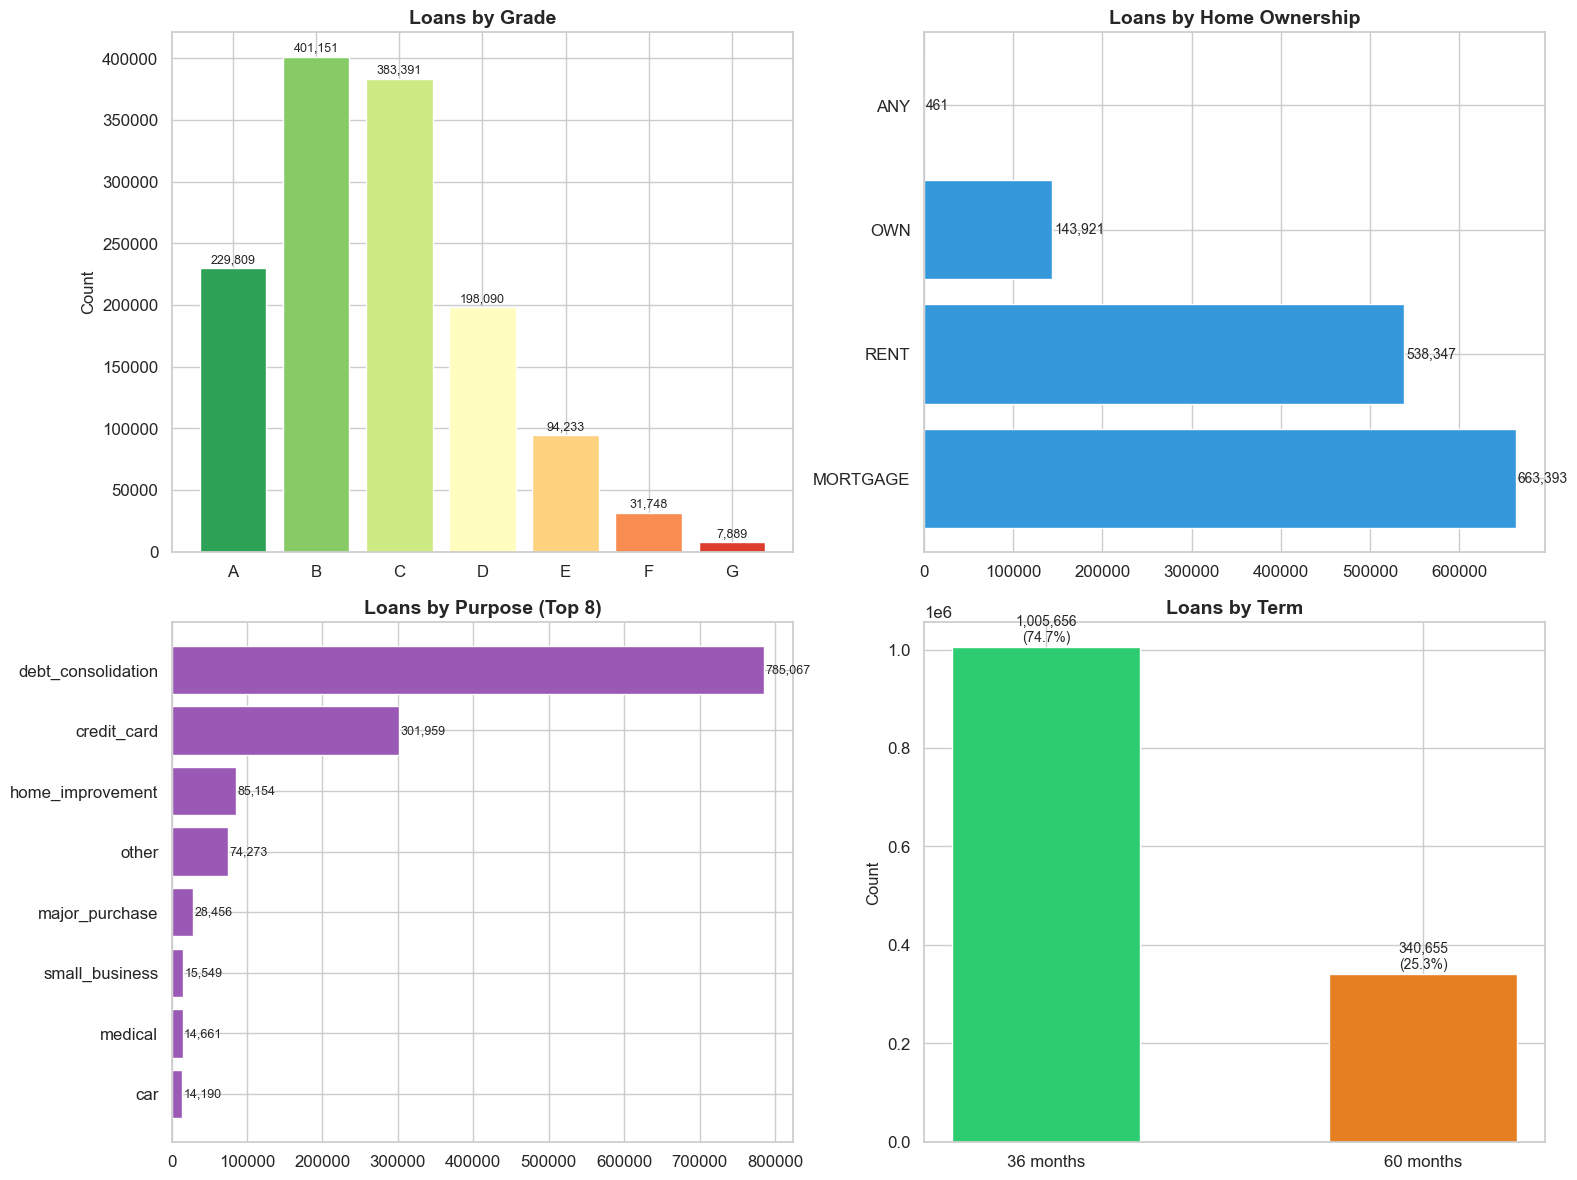

In [11]:
# Grade, Home Ownership, Purpose, Term distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

# Grade
grade_order = sorted(df["grade"].unique())
grade_counts = df["grade"].value_counts().reindex(grade_order)
bars = axes[0].bar(grade_order, grade_counts.values, color=sns.color_palette("RdYlGn_r", len(grade_order)))
for bar, val in zip(bars, grade_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2000,
                 f"{val:,.0f}", ha="center", va="bottom", fontsize=9)
axes[0].set_title("Loans by Grade", fontweight="bold")
axes[0].set_ylabel("Count")

# Home ownership
ho_counts = df["home_ownership"].value_counts().head(4)
axes[1].barh(ho_counts.index, ho_counts.values, color="#3498db")
for i, val in enumerate(ho_counts.values):
    axes[1].text(val + 2000, i, f"{val:,}", va="center", fontsize=10)
axes[1].set_title("Loans by Home Ownership", fontweight="bold")

# Purpose (top 8)
purpose_counts = df["purpose"].value_counts().head(8)
axes[2].barh(purpose_counts.index[::-1], purpose_counts.values[::-1], color="#9b59b6")
for i, val in enumerate(purpose_counts.values[::-1]):
    axes[2].text(val + 2000, i, f"{val:,}", va="center", fontsize=9)
axes[2].set_title("Loans by Purpose (Top 8)", fontweight="bold")

# Term
term_counts = df["term"].value_counts().sort_index()
bars = axes[3].bar(
    [f"{int(t)} months" for t in term_counts.index],
    term_counts.values, color=["#2ecc71", "#e67e22"], width=0.5
)
for bar, val in zip(bars, term_counts.values):
    axes[3].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000,
                 f"{val:,}\n({val/len(df)*100:.1f}%)", ha="center", va="bottom", fontsize=10)
axes[3].set_title("Loans by Term", fontweight="bold")
axes[3].set_ylabel("Count")

plt.tight_layout()
plt.show()

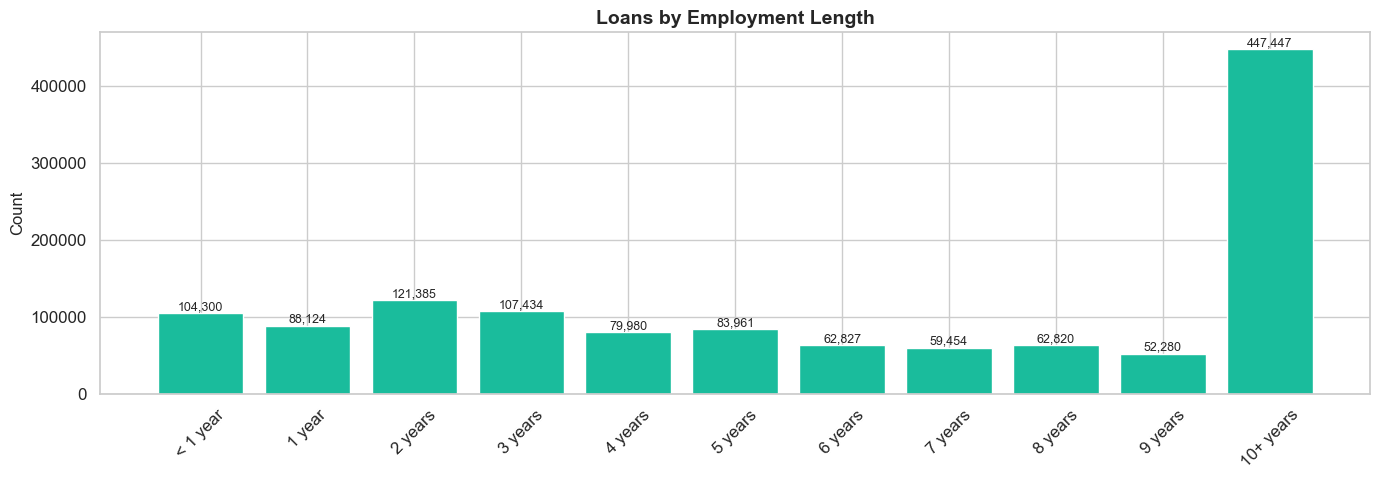

In [12]:
# Employment length analysis
emp_order = ["< 1 year", "1 year", "2 years", "3 years", "4 years",
             "5 years", "6 years", "7 years", "8 years", "9 years", "10+ years"]
emp_data = df.dropna(subset=["emp_length"])
emp_counts = emp_data["emp_length"].value_counts().reindex(emp_order)

fig, ax = plt.subplots(figsize=(14, 5))
bars = ax.bar(emp_order, emp_counts.values, color="#1abc9c", edgecolor="white")
for bar, val in zip(bars, emp_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
            f"{val:,}", ha="center", va="bottom", fontsize=9)
ax.set_title("Loans by Employment Length", fontweight="bold", fontsize=14)
ax.set_ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---
## 6. Bivariate Analysis: Default Rate by Segment

This is the most important section for credit risk — understanding which segments have higher default rates.

In [13]:
def plot_default_rate_by(df, col, order=None, top_n=None, ax=None, color="#e74c3c",
                          show_count=True, title=None):
    """Plot default rate by a categorical variable with loan count overlay."""
    summary = (
        df.groupby(col)["default_flag"]
        .agg(count="count", default_rate="mean")
        .reset_index()
    )
    if order:
        summary[col] = pd.Categorical(summary[col], categories=order, ordered=True)
        summary = summary.sort_values(col)
    elif top_n:
        summary = summary.nlargest(top_n, "count")
        summary = summary.sort_values("default_rate", ascending=False)
    else:
        summary = summary.sort_values("default_rate", ascending=False)

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 5))

    x = range(len(summary))
    labels = summary[col].astype(str).values

    bars = ax.bar(x, summary["default_rate"].values, color=color, alpha=0.8, edgecolor="white")

    for bar, rate, count in zip(bars, summary["default_rate"], summary["count"]):
        label = f"{rate:.1%}"
        if show_count:
            label += f"\n(n={count:,.0f})"
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                label, ha="center", va="bottom", fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45 if len(labels) > 6 else 0,
                       ha="right" if len(labels) > 6 else "center")
    ax.set_ylabel("Default Rate")
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    ax.set_title(title or f"Default Rate by {col}", fontweight="bold")

    overall = df["default_flag"].mean()
    ax.axhline(overall, color="#2c3e50", linestyle="--", alpha=0.6,
               label=f"Overall: {overall:.1%}")
    ax.legend()
    return ax

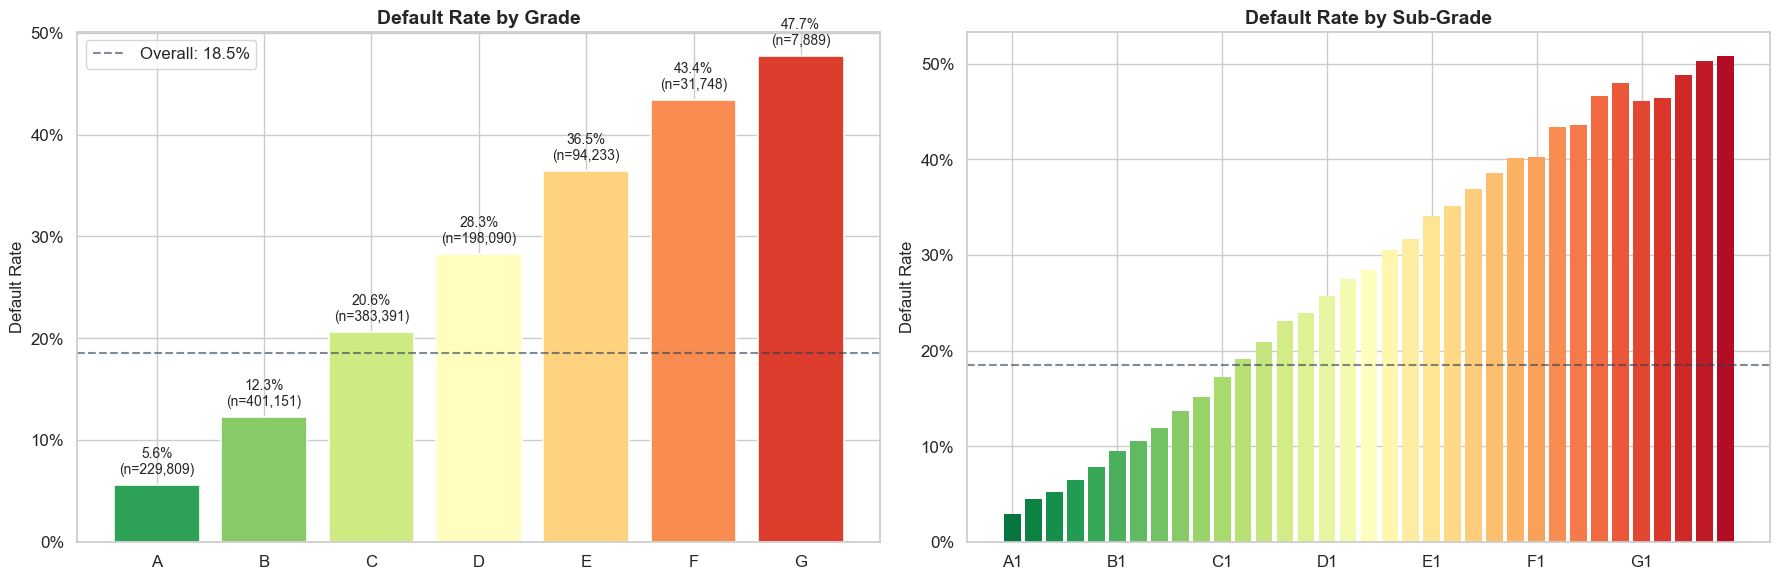


Default rate by grade:
grade            A      B      C      D      E      F      G
default_rate 5.63% 12.29% 20.64% 28.31% 36.47% 43.44% 47.71%


In [14]:
# Default rate by Grade — most important risk driver
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

grade_order = ["A", "B", "C", "D", "E", "F", "G"]
overall = df["default_flag"].mean()

# Grade
grade_summary = df.groupby("grade")["default_flag"].agg(count="count", default_rate="mean").reindex(grade_order)
colors_grade = sns.color_palette("RdYlGn_r", 7)
bars = axes[0].bar(grade_order, grade_summary["default_rate"].values,
                   color=colors_grade, edgecolor="white", linewidth=1.2)
for bar, rate, count in zip(bars, grade_summary["default_rate"], grade_summary["count"]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.008,
                 f"{rate:.1%}\n(n={count:,})", ha="center", va="bottom", fontsize=10)
axes[0].set_ylabel("Default Rate")
axes[0].yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
axes[0].set_title("Default Rate by Grade", fontweight="bold", fontsize=14)
axes[0].axhline(overall, color="#2c3e50", ls="--", alpha=0.6, label=f"Overall: {overall:.1%}")
axes[0].legend()

# Sub-Grade
sg_order = sorted(df["sub_grade"].unique())
sg_summary = df.groupby("sub_grade")["default_flag"].mean().reindex(sg_order)
axes[1].bar(range(len(sg_order)), sg_summary.values,
            color=sns.color_palette("RdYlGn_r", len(sg_order)), edgecolor="none")
axes[1].set_xticks(range(0, len(sg_order), 5))
axes[1].set_xticklabels([sg_order[i] for i in range(0, len(sg_order), 5)])
axes[1].set_ylabel("Default Rate")
axes[1].yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
axes[1].set_title("Default Rate by Sub-Grade", fontweight="bold", fontsize=14)
axes[1].axhline(overall, color="#2c3e50", ls="--", alpha=0.6)

plt.tight_layout()
plt.show()

print("\nDefault rate by grade:")
print(grade_summary[["default_rate"]].T.to_string(float_format="{:.2%}".format))

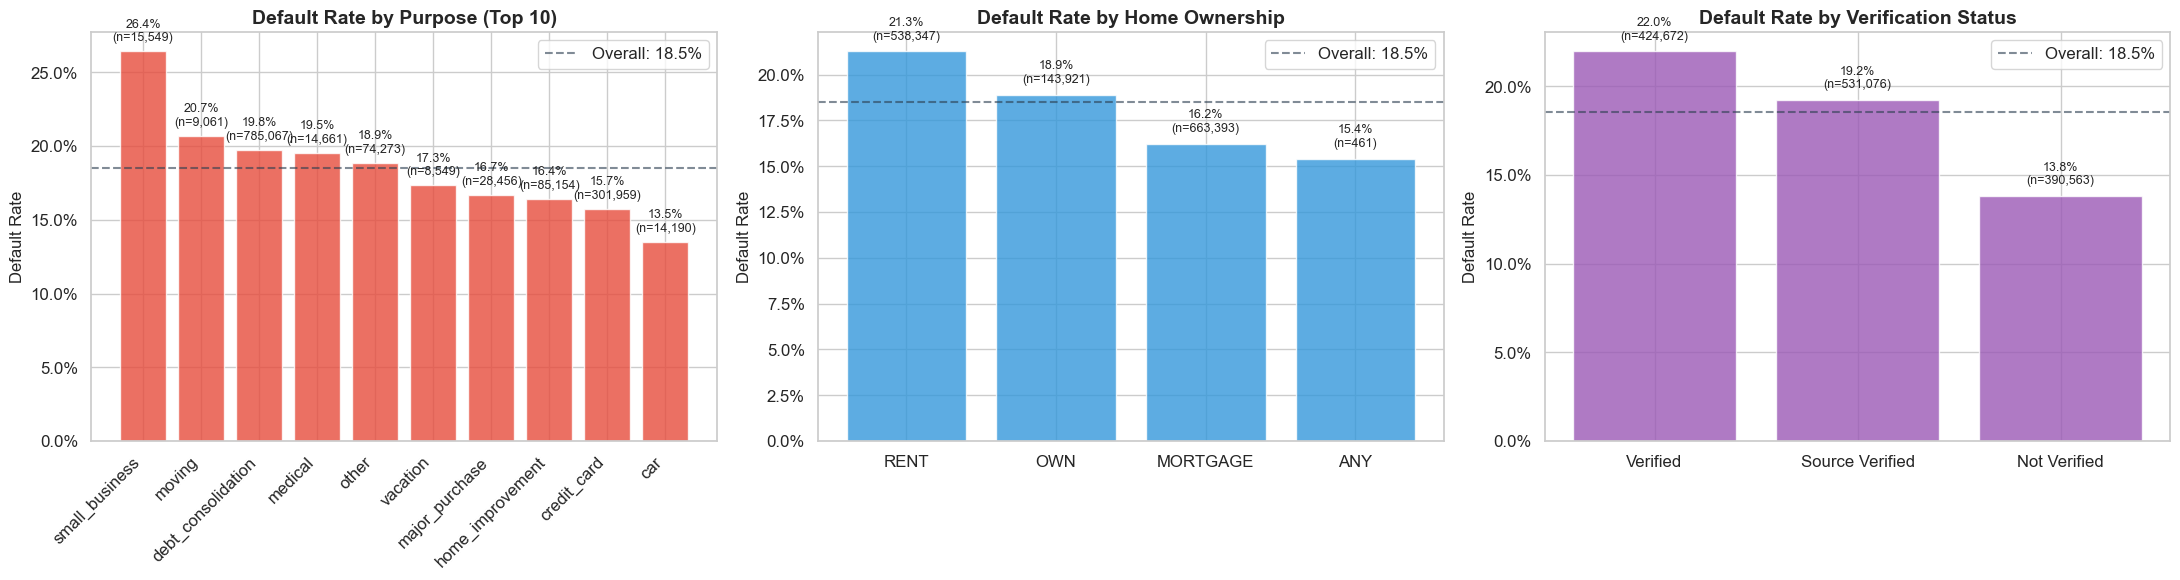

In [15]:
# Default rate by Purpose, Home Ownership, Verification Status
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

plot_default_rate_by(df, "purpose", top_n=10, ax=axes[0],
                      color="#e74c3c", title="Default Rate by Purpose (Top 10)")
plot_default_rate_by(df, "home_ownership", top_n=4, ax=axes[1],
                      color="#3498db", title="Default Rate by Home Ownership")
plot_default_rate_by(df, "verification_status", ax=axes[2],
                      color="#9b59b6", title="Default Rate by Verification Status")

plt.tight_layout()
plt.show()

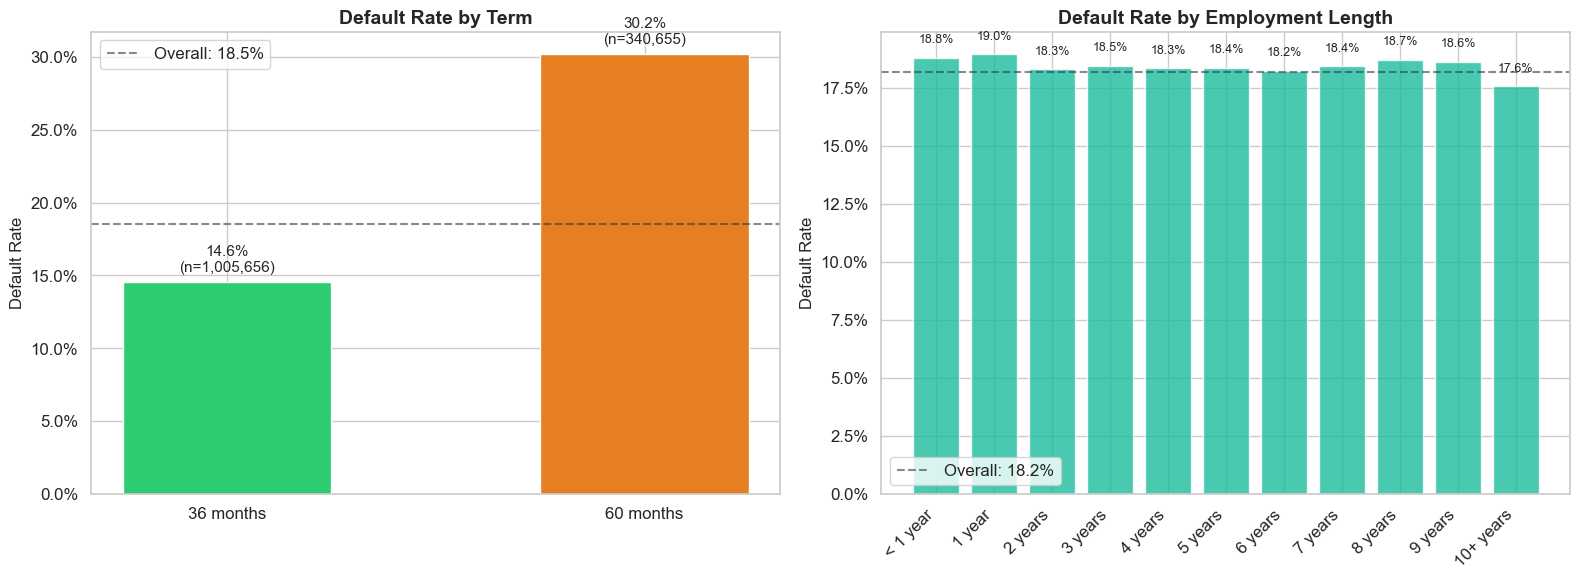

In [16]:
# Default rate by Term and Employment Length
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Term
term_summary = df.groupby("term")["default_flag"].agg(count="count", default_rate="mean").reset_index()
bars = axes[0].bar(
    [f"{int(t)} months" for t in term_summary["term"]],
    term_summary["default_rate"],
    color=["#2ecc71", "#e67e22"], width=0.5, edgecolor="white"
)
for bar, rate, count in zip(bars, term_summary["default_rate"], term_summary["count"]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f"{rate:.1%}\n(n={count:,})", ha="center", va="bottom", fontsize=11)
axes[0].set_ylabel("Default Rate")
axes[0].yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
axes[0].set_title("Default Rate by Term", fontweight="bold", fontsize=14)
axes[0].axhline(overall, color="#2c3e50", ls="--", alpha=0.6, label=f"Overall: {overall:.1%}")
axes[0].legend()

# Employment length
emp_order = ["< 1 year", "1 year", "2 years", "3 years", "4 years",
             "5 years", "6 years", "7 years", "8 years", "9 years", "10+ years"]
plot_default_rate_by(df.dropna(subset=["emp_length"]), "emp_length", order=emp_order,
                      ax=axes[1], color="#1abc9c", show_count=False,
                      title="Default Rate by Employment Length")

plt.tight_layout()
plt.show()

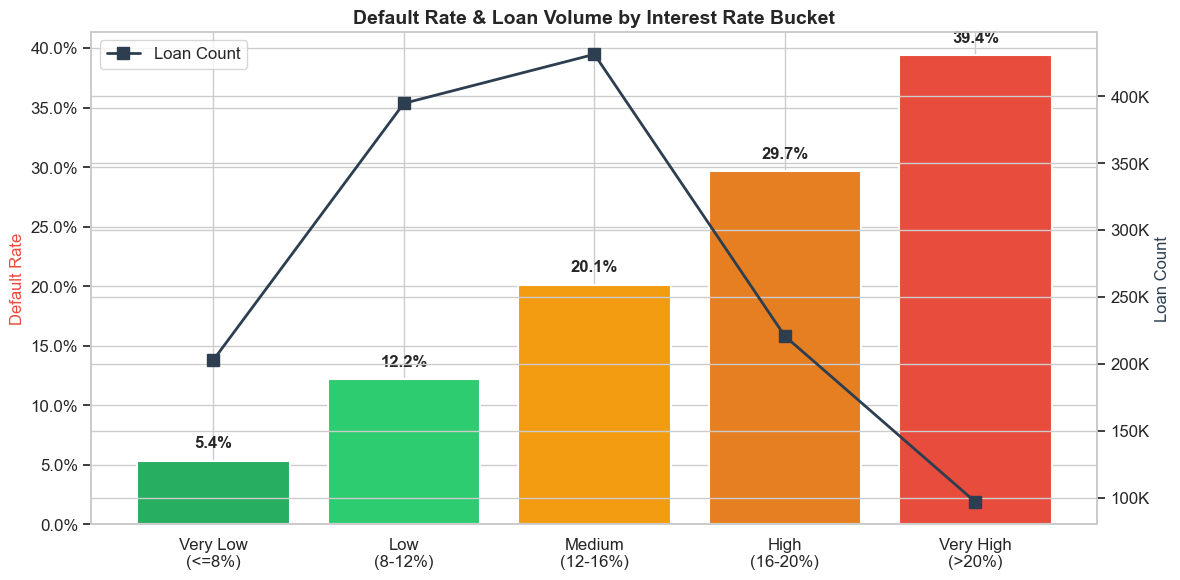


Interest rate bucket summary:
                  count  default_rate
int_rate_bucket                      
very_low         202806         5.36%
low              394764        12.19%
medium           431437        20.13%
high             220668        29.66%
very_high         96636        39.38%


In [17]:
# Default rate by Interest Rate Bucket — key risk stratification
bucket_order = ["very_low", "low", "medium", "high", "very_high"]
bucket_labels = ["Very Low\n(<=8%)", "Low\n(8-12%)", "Medium\n(12-16%)", "High\n(16-20%)", "Very High\n(>20%)"]
bucket_summary = (
    df.groupby("int_rate_bucket", observed=True)["default_flag"]
    .agg(count="count", default_rate="mean")
    .reindex(bucket_order)
)

fig, ax1 = plt.subplots(figsize=(12, 6))

colors_bucket = ["#27ae60", "#2ecc71", "#f39c12", "#e67e22", "#e74c3c"]
x = range(len(bucket_order))
bars = ax1.bar(x, bucket_summary["default_rate"], color=colors_bucket, edgecolor="white", linewidth=1.5)
ax1.set_ylabel("Default Rate", color="#e74c3c", fontsize=12)
ax1.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

for bar, rate in zip(bars, bucket_summary["default_rate"]):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.008,
             f"{rate:.1%}", ha="center", va="bottom", fontweight="bold", fontsize=12)

ax2 = ax1.twinx()
ax2.plot(x, bucket_summary["count"], "s-", color="#2c3e50", markersize=8, linewidth=2, label="Loan Count")
ax2.set_ylabel("Loan Count", color="#2c3e50", fontsize=12)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e3:.0f}K"))

ax1.set_xticks(x)
ax1.set_xticklabels(bucket_labels)
ax1.set_title("Default Rate & Loan Volume by Interest Rate Bucket", fontweight="bold", fontsize=14)
ax2.legend(loc="upper left")

plt.tight_layout()
plt.show()

print("\nInterest rate bucket summary:")
print(bucket_summary.to_string(float_format="{:.2%}".format))

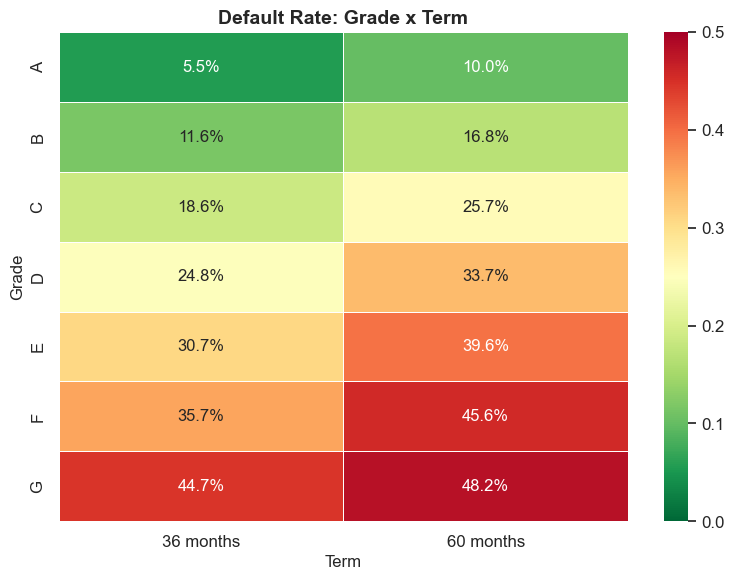

In [18]:
# Heatmap: Default rate by Grade x Term
grade_term = df.pivot_table(
    values="default_flag", index="grade", columns="term", aggfunc="mean"
).reindex(["A", "B", "C", "D", "E", "F", "G"])
grade_term.columns = [f"{int(c)} months" for c in grade_term.columns]

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    grade_term, annot=True, fmt=".1%", cmap="RdYlGn_r",
    linewidths=0.5, ax=ax, vmin=0, vmax=0.5,
    annot_kws={"fontsize": 12}
)
ax.set_title("Default Rate: Grade x Term", fontweight="bold", fontsize=14)
ax.set_ylabel("Grade")
ax.set_xlabel("Term")
plt.tight_layout()
plt.show()

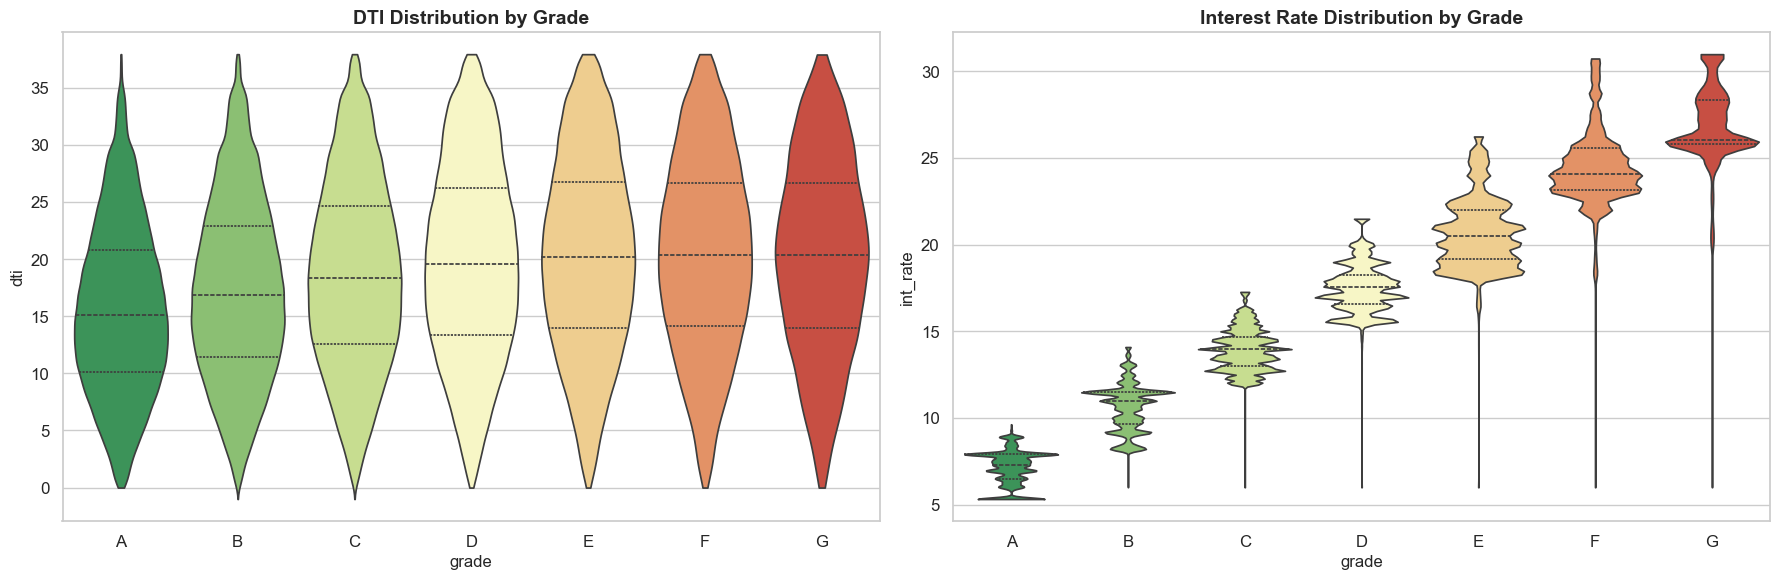

In [19]:
# Violin plots: DTI and int_rate distribution by Grade
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

grade_order = ["A", "B", "C", "D", "E", "F", "G"]

# DTI by Grade
df_plot = df[df["dti"] <= df["dti"].quantile(0.99)].copy()
sns.violinplot(data=df_plot, x="grade", y="dti", order=grade_order,
               palette="RdYlGn_r", ax=axes[0], inner="quartile", cut=0)
axes[0].set_title("DTI Distribution by Grade", fontweight="bold", fontsize=14)

# Interest Rate by Grade
sns.violinplot(data=df, x="grade", y="int_rate", order=grade_order,
               palette="RdYlGn_r", ax=axes[1], inner="quartile", cut=0)
axes[1].set_title("Interest Rate Distribution by Grade", fontweight="bold", fontsize=14)

plt.tight_layout()
plt.show()

---
## 7. Temporal Trends

Analyze loan origination volume and default rate evolution over time — critical for our Out-of-Time validation strategy.

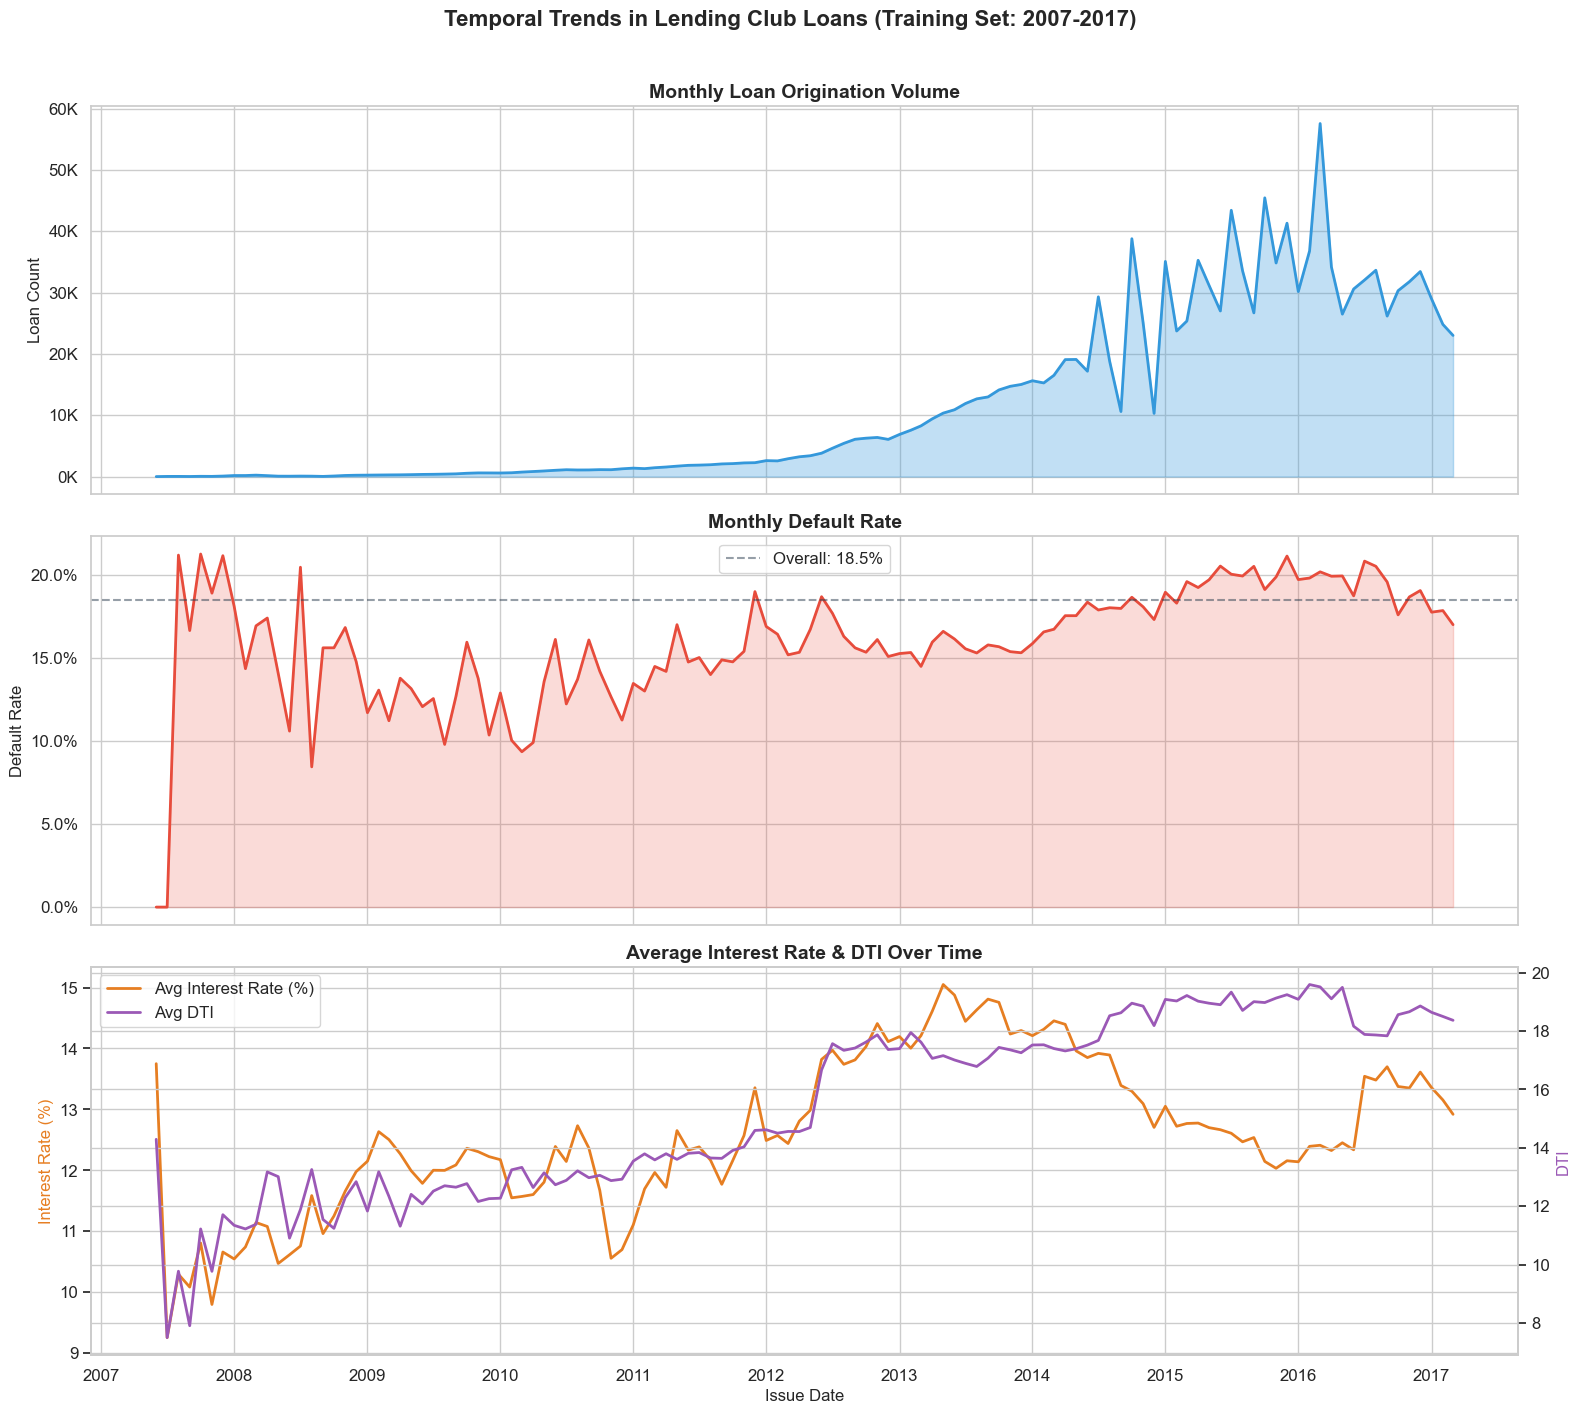

In [20]:
# Monthly time series
df["issue_month"] = df["issue_d"].dt.to_period("M").dt.to_timestamp()
monthly = (
    df.groupby("issue_month")
    .agg(
        loan_count=("default_flag", "count"),
        default_rate=("default_flag", "mean"),
        total_funded=("loan_amnt", "sum"),
        avg_loan_amnt=("loan_amnt", "mean"),
        avg_int_rate=("int_rate", "mean"),
        avg_dti=("dti", "mean"),
    )
    .reset_index()
)

fig, axes = plt.subplots(3, 1, figsize=(16, 14), sharex=True)

# Panel 1: Loan origination volume
axes[0].fill_between(monthly["issue_month"], monthly["loan_count"],
                      alpha=0.3, color="#3498db")
axes[0].plot(monthly["issue_month"], monthly["loan_count"], "-",
             color="#3498db", linewidth=2)
axes[0].set_ylabel("Loan Count")
axes[0].set_title("Monthly Loan Origination Volume", fontweight="bold", fontsize=14)
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e3:.0f}K"))

# Panel 2: Default rate
axes[1].plot(monthly["issue_month"], monthly["default_rate"], "-",
             color="#e74c3c", linewidth=2)
axes[1].fill_between(monthly["issue_month"], monthly["default_rate"],
                      alpha=0.2, color="#e74c3c")
axes[1].set_ylabel("Default Rate")
axes[1].yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
axes[1].set_title("Monthly Default Rate", fontweight="bold", fontsize=14)
axes[1].axhline(df["default_flag"].mean(), color="#2c3e50", ls="--", alpha=0.5,
                label=f"Overall: {df['default_flag'].mean():.1%}")
axes[1].legend()

# Panel 3: Average interest rate and DTI
ax3a = axes[2]
ax3b = ax3a.twinx()
ax3a.plot(monthly["issue_month"], monthly["avg_int_rate"], "-",
          color="#e67e22", linewidth=2, label="Avg Interest Rate (%)")
ax3b.plot(monthly["issue_month"], monthly["avg_dti"], "-",
          color="#9b59b6", linewidth=2, label="Avg DTI")
ax3a.set_ylabel("Interest Rate (%)", color="#e67e22")
ax3b.set_ylabel("DTI", color="#9b59b6")
ax3a.set_title("Average Interest Rate & DTI Over Time", fontweight="bold", fontsize=14)
lines1, labels1 = ax3a.get_legend_handles_labels()
lines2, labels2 = ax3b.get_legend_handles_labels()
ax3a.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

axes[2].set_xlabel("Issue Date")

fig.suptitle("Temporal Trends in Lending Club Loans (Training Set: 2007-2017)",
             fontsize=16, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

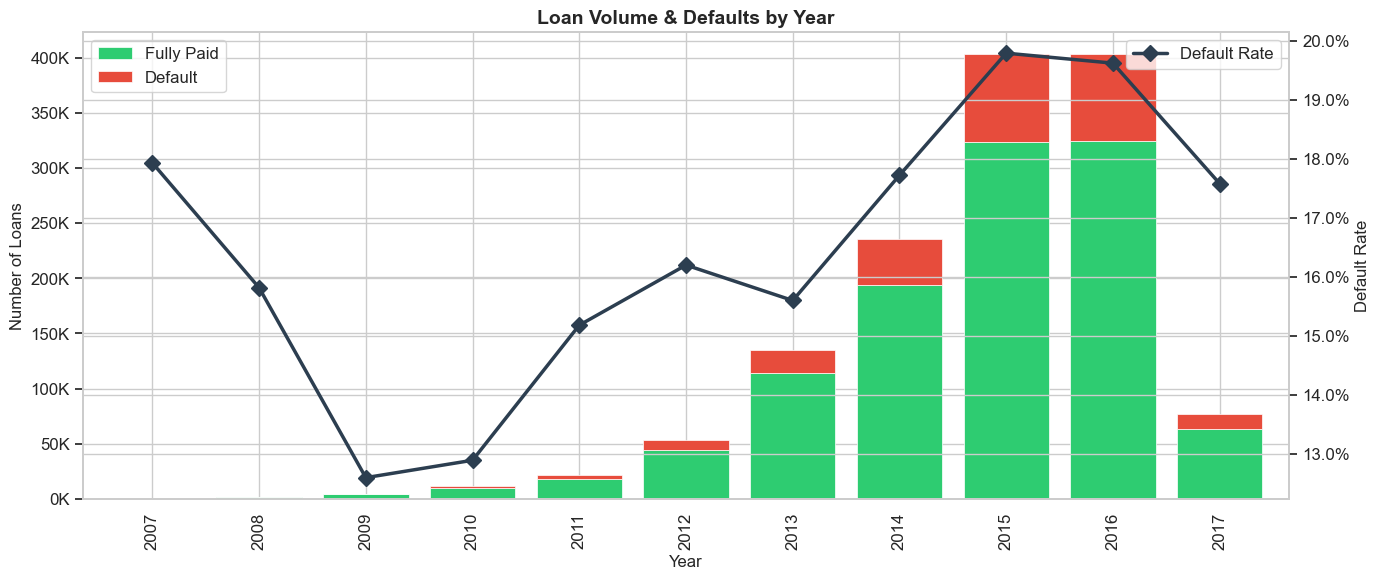


Yearly summary:
 issue_year  loan_count default_rate total_funded
       2007         251       17.93%          $2M
       2008        1562       15.81%         $14M
       2009        4716       12.60%         $46M
       2010       11536       12.89%        $122M
       2011       21721       15.18%        $262M
       2012       53367       16.20%        $718M
       2013      134814       15.60%       $1983M
       2014      235619       17.72%       $3504M
       2015      402837       19.79%       $6049M
       2016      403104       19.62%       $5761M
       2017       76784       17.58%       $1092M


In [21]:
# Yearly default rate evolution with volume
df["issue_year"] = df["issue_d"].dt.year
yearly = df.groupby("issue_year").agg(
    loan_count=("default_flag", "count"),
    default_rate=("default_flag", "mean"),
    total_funded=("loan_amnt", "sum"),
).reset_index()

fig, ax1 = plt.subplots(figsize=(14, 6))

# Stacked bars: defaults vs non-defaults
yearly_default = df.groupby(["issue_year", "default_flag"]).size().unstack(fill_value=0)
yearly_default.columns = ["Fully Paid", "Default"]

yearly_default.plot.bar(
    stacked=True, color=[COLORS_DEFAULT[0], COLORS_DEFAULT[1]],
    ax=ax1, edgecolor="white", linewidth=0.5, width=0.8
)
ax1.set_ylabel("Number of Loans")
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e3:.0f}K"))
ax1.set_xlabel("Year")
ax1.set_title("Loan Volume & Defaults by Year", fontweight="bold", fontsize=14)
ax1.legend(loc="upper left")

# Default rate line on secondary axis
ax2 = ax1.twinx()
ax2.plot(range(len(yearly)), yearly["default_rate"].values, "D-",
         color="#2c3e50", markersize=8, linewidth=2.5, label="Default Rate", zorder=5)
ax2.set_ylabel("Default Rate")
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

print("\nYearly summary:")
yearly_display = yearly.copy()
yearly_display["default_rate"] = yearly_display["default_rate"].apply(lambda x: f"{x:.2%}")
yearly_display["total_funded"] = yearly_display["total_funded"].apply(lambda x: f"${x/1e6:.0f}M")
print(yearly_display.to_string(index=False))

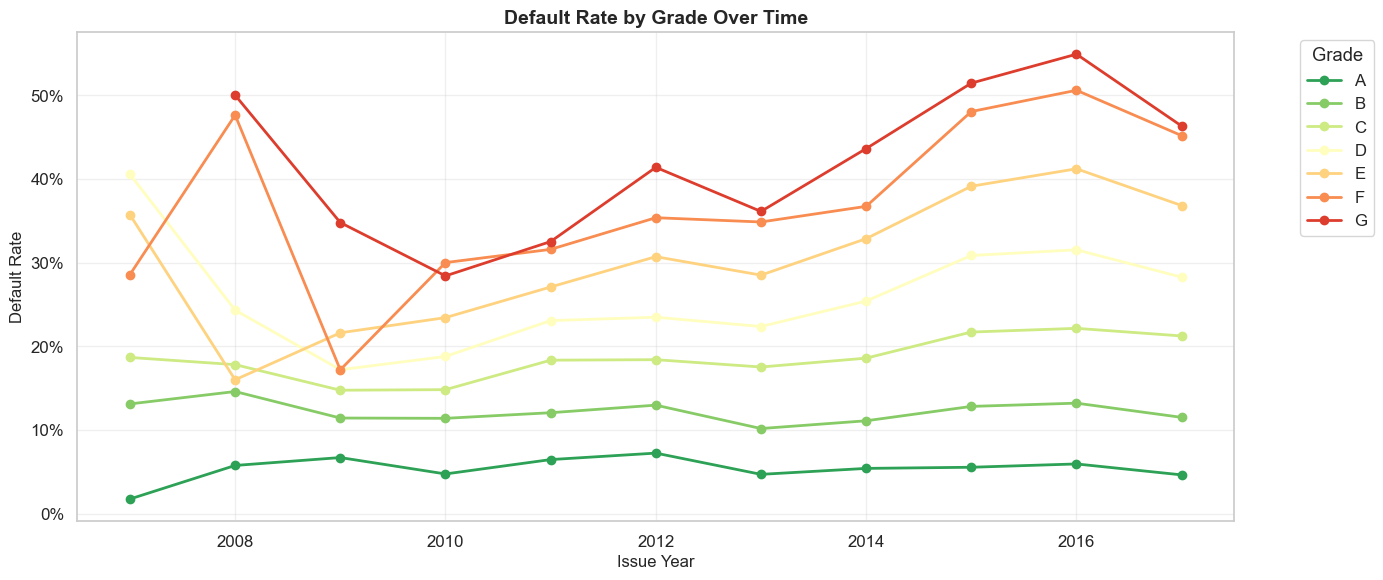

In [22]:
# Default rate by Grade over time — grade migration risk
grade_time = df.pivot_table(
    values="default_flag", index="issue_year", columns="grade", aggfunc="mean"
)[grade_order]

fig, ax = plt.subplots(figsize=(14, 6))
colors_grade = sns.color_palette("RdYlGn_r", 7)
for i, grade in enumerate(grade_order):
    ax.plot(grade_time.index, grade_time[grade], "o-", label=grade,
            color=colors_grade[i], linewidth=2, markersize=6)

ax.set_xlabel("Issue Year")
ax.set_ylabel("Default Rate")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.set_title("Default Rate by Grade Over Time", fontweight="bold", fontsize=14)
ax.legend(title="Grade", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 8. Correlation Analysis

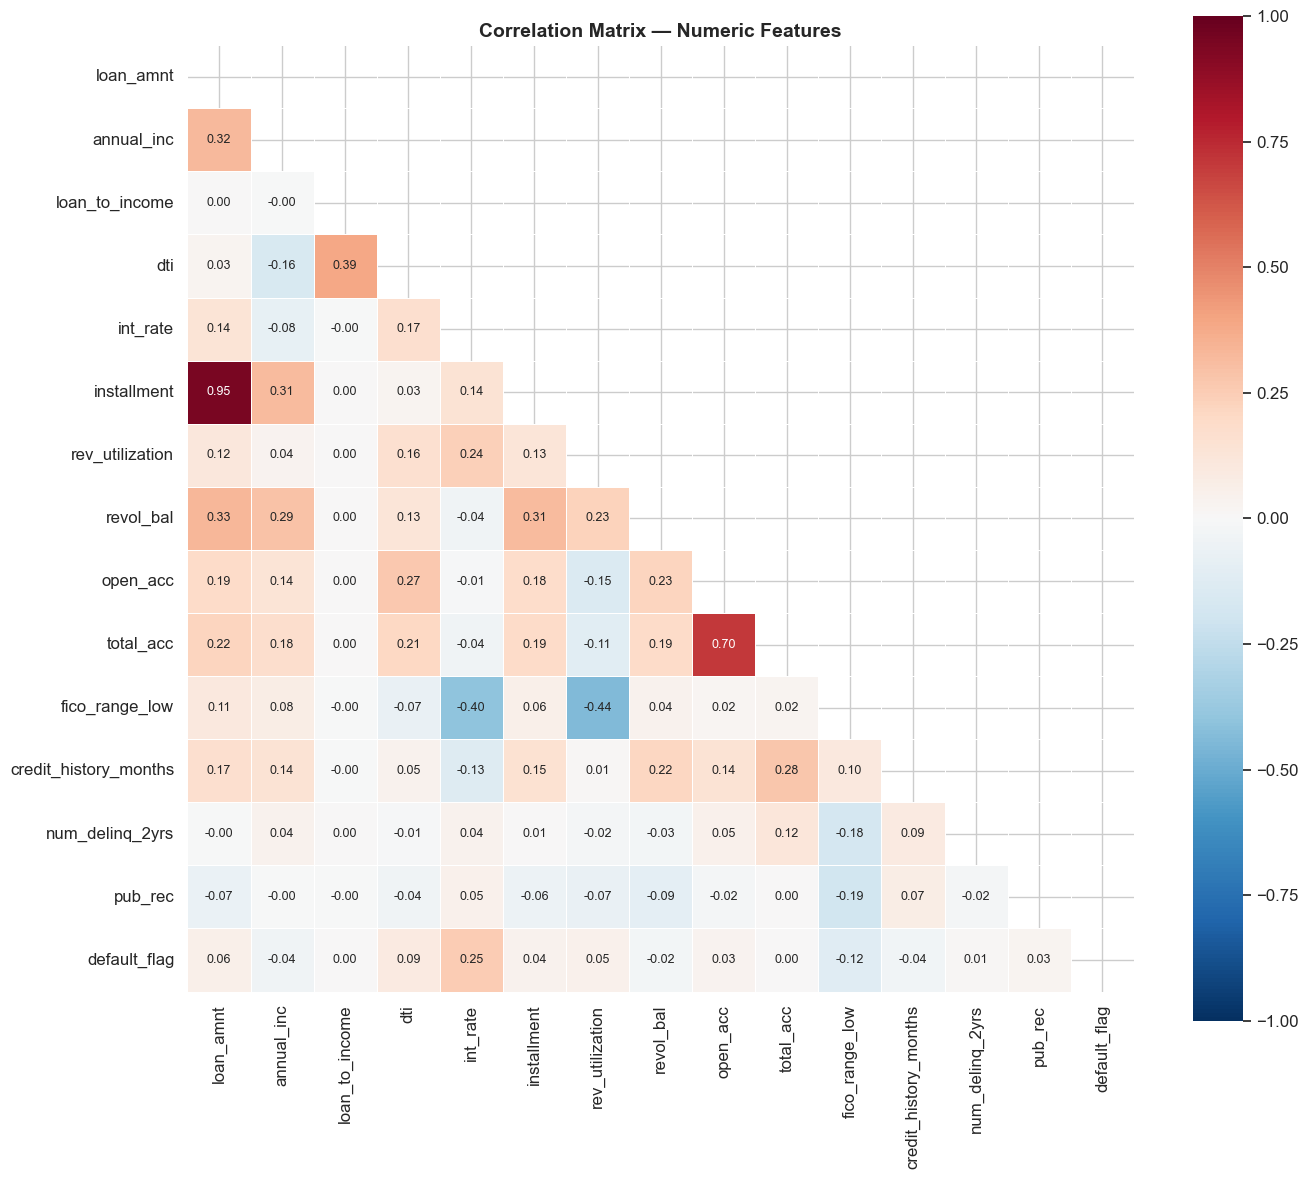

In [23]:
# Correlation matrix — numeric features
corr_cols = [
    "loan_amnt", "annual_inc", "loan_to_income", "dti", "int_rate",
    "installment", "rev_utilization", "revol_bal", "open_acc", "total_acc",
    "fico_range_low", "credit_history_months", "num_delinq_2yrs",
    "pub_rec", "default_flag"
]
corr_matrix = df[corr_cols].corr()

# Mask upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt=".2f",
    cmap="RdBu_r", center=0, vmin=-1, vmax=1,
    square=True, linewidths=0.5, ax=ax,
    annot_kws={"fontsize": 9}
)
ax.set_title("Correlation Matrix — Numeric Features", fontweight="bold", fontsize=14)
plt.tight_layout()
plt.show()

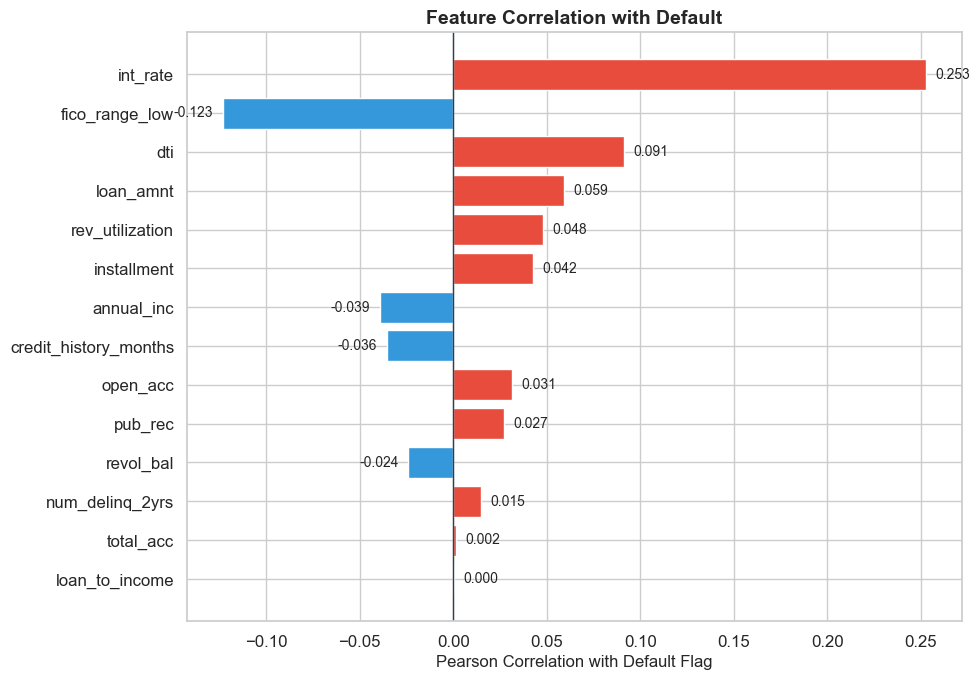


Top correlations with default_flag:
  int_rate                       +0.2529  (+) higher = more default
  fico_range_low                 -0.1232  (-) higher = less default
  dti                            +0.0911  (+) higher = more default
  loan_amnt                      +0.0593  (+) higher = more default
  rev_utilization                +0.0482  (+) higher = more default
  installment                    +0.0425  (+) higher = more default
  annual_inc                     -0.0393  (-) higher = less default
  credit_history_months          -0.0355  (-) higher = less default
  open_acc                       +0.0315  (+) higher = more default
  pub_rec                        +0.0273  (+) higher = more default
  revol_bal                      -0.0240  (-) higher = less default
  num_delinq_2yrs                +0.0149  (+) higher = more default
  total_acc                      +0.0017  (+) higher = more default
  loan_to_income                 +0.0003  (+) higher = more default


In [24]:
# Correlations with default_flag — ranked
corr_with_target = (
    corr_matrix["default_flag"]
    .drop("default_flag")
    .sort_values(key=abs, ascending=False)
)

fig, ax = plt.subplots(figsize=(10, 7))
colors = ["#e74c3c" if v > 0 else "#3498db" for v in corr_with_target.values]
bars = ax.barh(corr_with_target.index[::-1], corr_with_target.values[::-1],
               color=colors[::-1], edgecolor="white")
ax.axvline(0, color="#2c3e50", linewidth=1)
ax.set_xlabel("Pearson Correlation with Default Flag")
ax.set_title("Feature Correlation with Default", fontweight="bold", fontsize=14)

for bar, val in zip(bars, corr_with_target.values[::-1]):
    ax.text(val + (0.005 if val >= 0 else -0.005), bar.get_y() + bar.get_height()/2,
            f"{val:.3f}", ha="left" if val >= 0 else "right", va="center", fontsize=10)

plt.tight_layout()
plt.show()

print("\nTop correlations with default_flag:")
for feat, corr in corr_with_target.items():
    direction = "(+) higher = more default" if corr > 0 else "(-) higher = less default"
    print(f"  {feat:30s} {corr:+.4f}  {direction}")

---
## 9. Outlier Detection

In [25]:
# IQR-based outlier detection
outlier_cols = ["loan_amnt", "annual_inc", "dti", "int_rate",
                "revol_bal", "installment", "rev_utilization"]

outlier_results = []
for col in outlier_cols:
    data = df[col].dropna()
    q1, q3 = data.quantile(0.25), data.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    n_outliers = ((data < lower) | (data > upper)).sum()
    pct_outliers = n_outliers / len(data) * 100

    outlier_results.append({
        "feature": col,
        "Q1": q1, "Q3": q3, "IQR": iqr,
        "lower_fence": lower, "upper_fence": upper,
        "n_outliers": n_outliers, "pct_outliers": pct_outliers,
    })

outlier_df = pd.DataFrame(outlier_results).set_index("feature")
outlier_df[["Q1", "Q3", "IQR", "lower_fence", "upper_fence"]] = (
    outlier_df[["Q1", "Q3", "IQR", "lower_fence", "upper_fence"]].round(2)
)
outlier_df["pct_outliers"] = outlier_df["pct_outliers"].round(2)
outlier_df

,Q1,Q3,IQR,lower_fence,upper_fence,n_outliers,pct_outliers
feature,,,,,,,
loan_amnt,8000.00,20000.00,12000.00,-10000.00,38000.00,4237,0.31
annual_inc,46000.00,90000.00,44000.00,-20000.00,156000.00,66511,4.94
dti,11.99,24.17,12.18,-6.28,42.44,2869,0.21
int_rate,9.71,15.80,6.09,0.58,24.94,23315,1.73
revol_bal,6212.00,20285.00,14073.00,-14897.50,41394.50,78920,5.86
installment,251.58,578.42,326.84,-238.68,1068.68,41409,3.08
rev_utilization,0.35,0.72,0.36,-0.19,1.27,84,0.01


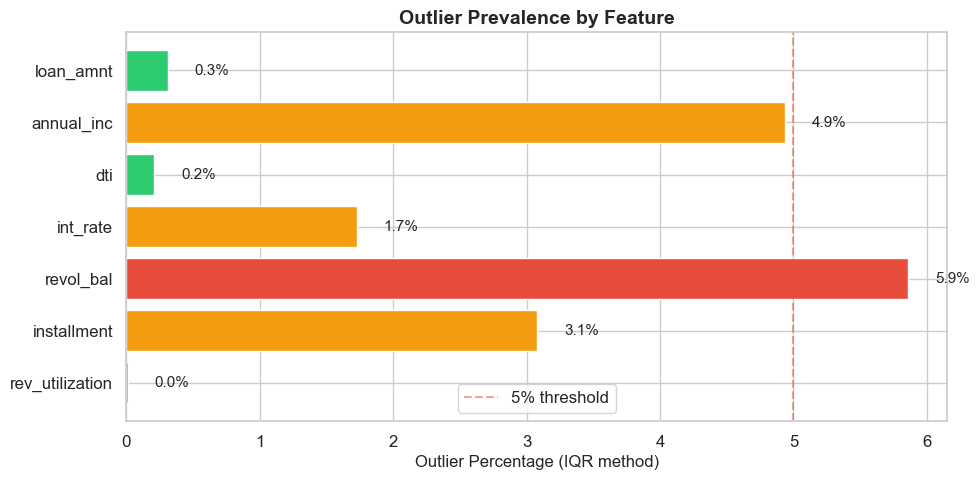

In [26]:
# Outlier percentage visualization
fig, ax = plt.subplots(figsize=(10, 5))
colors_outlier = ["#e74c3c" if p > 5 else "#f39c12" if p > 1 else "#2ecc71"
                  for p in outlier_df["pct_outliers"]]
bars = ax.barh(outlier_df.index[::-1], outlier_df["pct_outliers"].values[::-1],
               color=colors_outlier[::-1], edgecolor="white")
for bar, pct in zip(bars, outlier_df["pct_outliers"].values[::-1]):
    ax.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2,
            f"{pct:.1f}%", va="center", fontsize=11)
ax.set_xlabel("Outlier Percentage (IQR method)")
ax.set_title("Outlier Prevalence by Feature", fontweight="bold", fontsize=14)
ax.axvline(5, color="#e74c3c", ls="--", alpha=0.5, label="5% threshold")
ax.legend()
plt.tight_layout()
plt.show()

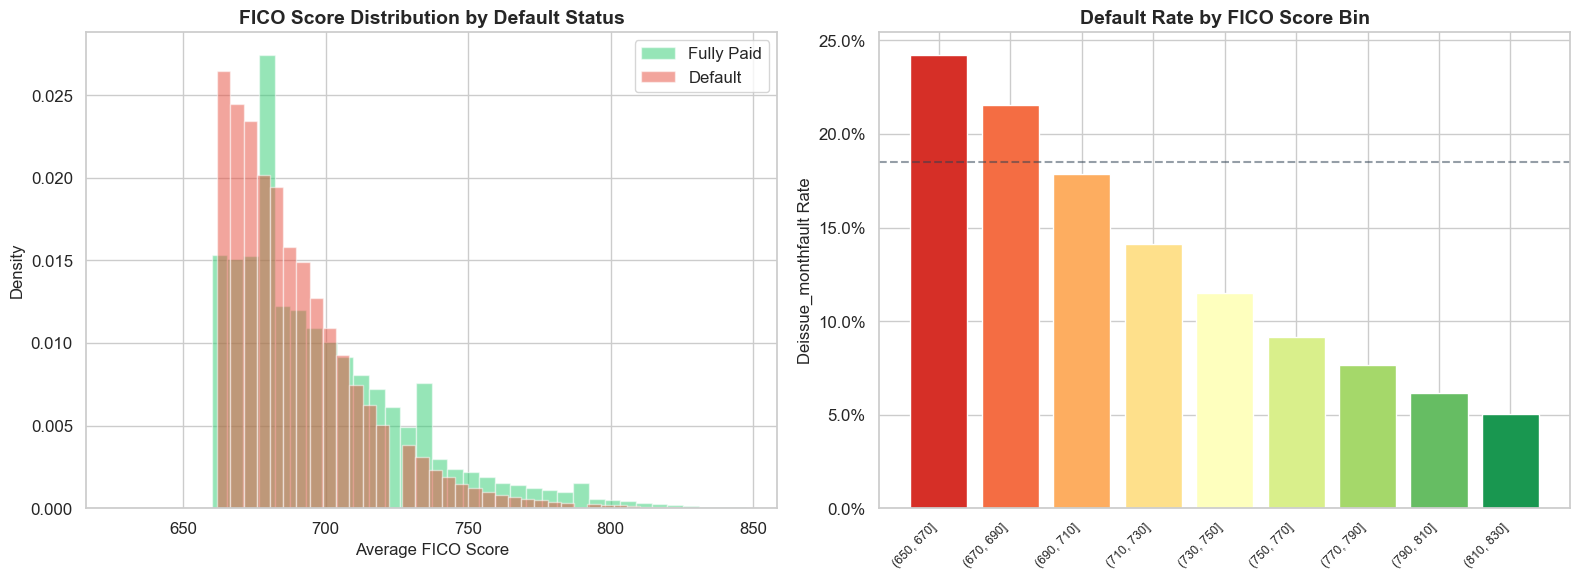

In [27]:
# FICO score analysis — important credit risk indicator
df["fico_avg"] = (df["fico_range_low"] + df["fico_range_high"]) / 2

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# FICO distribution by default status
for flag in [0, 1]:
    subset = df[df["default_flag"] == flag]["fico_avg"]
    axes[0].hist(subset, bins=40, alpha=0.5, density=True,
                 color=COLORS_DEFAULT[flag], label=LABEL_DEFAULT[flag])
axes[0].set_xlabel("Average FICO Score")
axes[0].set_ylabel("Density")
axes[0].set_title("FICO Score Distribution by Default Status", fontweight="bold")
axes[0].legend()

# FICO bins vs default rate
fico_bins = pd.cut(df["fico_avg"], bins=range(650, 850, 20))
fico_summary = df.groupby(fico_bins, observed=True)["default_flag"].agg(
    count="count", default_rate="mean"
).reset_index()
fico_summary["label"] = fico_summary["fico_avg"].astype(str)

ax1 = axes[1]
bars = ax1.bar(range(len(fico_summary)), fico_summary["default_rate"],
               color=sns.color_palette("RdYlGn", len(fico_summary)), edgecolor="white")
ax1.set_xticks(range(len(fico_summary)))
ax1.set_xticklabels(fico_summary["label"], rotation=45, ha="right", fontsize=9)
ax1.set_ylabel("Deissue_monthfault Rate")
ax1.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax1.set_title("Default Rate by FICO Score Bin", fontweight="bold")
ax1.axhline(overall, color="#2c3e50", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Clean up temp columns
df.drop(columns=["fico_avg", "", "issue_year"], inplace=True, errors="ignore")

---
## 10. Key Findings & Next Steps

### Dataset Summary
- **1.35M training loans** (2007-2017), with 277K OOT test set (2018-2020)
- **18.5% overall default rate** (includes "Charged Off" + "Default" statuses)
- **32 features** after feature engineering (numeric, categorical, interactions)

### Key Risk Patterns

| Finding | Detail |
|---------|--------|
| **Grade is the strongest risk discriminator** | Grade A: ~7% default -> Grade G: ~37% default |
| **Interest rate monotonically predicts default** | Very Low bucket: ~8% -> Very High: ~32% |
| **60-month loans are riskier** | ~28% default vs ~15% for 36-month |
| **Small business loans highest-risk purpose** | ~26% default rate |
| **FICO score inversely correlated with default** | Lower FICO = higher default |
| **Temporal shift in default rates** | Older vintages (2007-2010) show higher rates |

### Correlation Insights
- `int_rate` has the highest positive correlation with default
- `fico_range_low` / `fico_range_high` have the strongest negative correlation
- `loan_amnt` and `installment` are highly correlated (>0.9) — potential multicollinearity

### Data Quality Notes
- `days_since_last_delinq`: ~50% null (expected — only delinquent borrowers)
- `emp_length`: ~6% null — CatBoost handles natively
- Outliers in `annual_inc` and `revol_bal` — consider winsorization for LogReg baseline

### Next Steps
1. **Notebook 02**: Feature Engineering — WOE encoding with OptBinning, IV filtering
2. **Notebook 03**: PD Modeling — LogReg baseline + CatBoost + Optuna HPO
3. **Notebook 04**: Conformal Prediction — MAPIE intervals with coverage validation

## Final Conclusions: EDA

### Key Findings
- The portfolio shows strong temporal non-stationarity in origination volume and default behavior.
- Target prevalence and segment composition shift materially over time, so random splits would overstate model quality.
- Several raw fields carry post-origination information, confirming the need for strict leakage controls.

### Financial Risk Interpretation
- Time drift implies that point-in-time score performance can degrade without out-of-time validation.
- Changes in borrower mix and underwriting cycles are structural risk drivers, not random noise.
- Risk limits and provisioning assumptions must be stress-aware, not static.

### Contribution to End-to-End Pipeline
- Defines the correct validation protocol (out-of-time split) used by all downstream modeling.
- Identifies leakage and data quality constraints that shape feature engineering and model governance.
- Provides the baseline context for interpreting uncertainty, ECL, and optimization results later in the pipeline.